In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import pickle
from cautious_extrapolation.data_paths import DATA_PATHS 
from cautious_extrapolation.utils import get_imagenet_features, kl_divergence_gaussian
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from wilds import get_dataset

/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
dir_path = os.path.dirname(os.path.abspath("__file__"))
test_countries = ['train', 'benin', 'burkina_faso', 'guinea', 'sierra_leone', 'tanzania', 'angola', 'cote_d_ivoire', 'ethiopia', 'mali', 'rwanda']


run_names = ["seed1_2023_06_02_11_50_14",
             "seed2_2023_06_02_12_07_54",
             "seed3_2023_06_02_12_08_17"]

mses_all = []
std_squared_errors_all = []
for run_name in run_names:
    with open(os.path.join(dir_path, "data", run_name, "outputs.pkl"), 'rb') as f:
        data = pickle.load(f)

    mses = []
    std_squared_errors = []
    for country in test_countries:
        mses.append(np.median(data[country][:, 2]))
        std_squared_errors.append(np.median((data[country][:, 1]-0.8)**2))
    mses_all.append(mses)
    std_squared_errors_all.append(std_squared_errors)


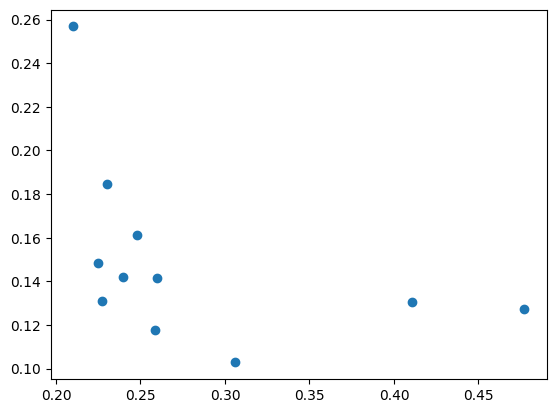

In [15]:
mses_all = np.array(mses_all)
std_squared_errors_all = np.array(std_squared_errors_all)
plt.scatter(np.sqrt(mses_all.mean(axis=0)), std_squared_errors_all.mean(axis=0))

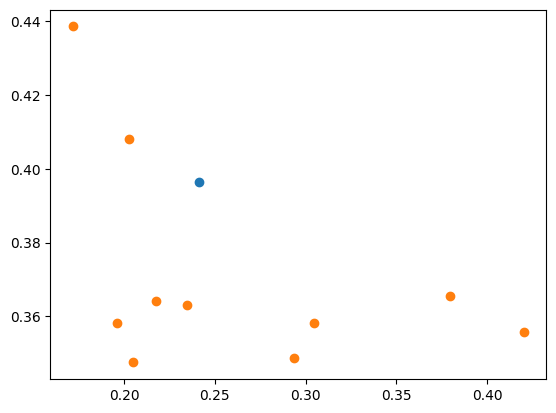

In [22]:
plt.scatter([data["train"][:, 2].mean()], np.mean((data["train"][:, 1]-0.8)**2))
plt.scatter(mses, stds)

In [12]:
dataset = get_dataset(dataset="poverty", download=True, root_dir=DATA_PATHS["nfs"]["poverty"])

In [13]:
features_dict= {}
val_data = dataset.get_subset(
    "id_val")

val_loader = torch.utils.data.DataLoader(
    val_data,
    batch_size=64, shuffle=True,
    num_workers=4, pin_memory=True)

train_features = get_imagenet_features(val_loader, poverty=True)
features_dict["train"] = train_features

/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
test_countries = ['benin', 'burkina_faso', 'guinea', 'sierra_leone', 'tanzania', 'angola', 'cote_d_ivoire', 'ethiopia', 'mali', 'rwanda']

for country in test_countries:
    print(country)
    country_metadata_idx = dataset._metadata_map["country"].index(country)
    country_idxs = np.where(dataset._metadata_array[:, 2] == country_metadata_idx)
    country_data = torch.utils.data.Subset(dataset, country_idxs[0])
    country_loader = torch.utils.data.DataLoader(
        country_data,
        batch_size=64, shuffle=True,
        num_workers=4, pin_memory=True)
    features_dict[country] = get_imagenet_features(country_loader, poverty=True)

benin
burkina_faso
guinea
sierra_leone
tanzania
angola
cote_d_ivoire
ethiopia
mali
rwanda


In [16]:
test_countries

['benin',
 'burkina_faso',
 'guinea',
 'sierra_leone',
 'tanzania',
 'angola',
 'cote_d_ivoire',
 'ethiopia',
 'mali',
 'rwanda']

In [23]:
ood_scores_all = []

for country in test_countries:
    print(country)
    cutoff = min(len(features_dict[country]), len(features_dict["train"]))
    ood_features = features_dict[country][:cutoff]
    val_features = features_dict["train"][:cutoff]
    X = np.concatenate((val_features, ood_features), axis=0)
    y = np.concatenate((np.ones(cutoff), np.zeros(cutoff)), axis=0)
    idxs = np.random.permutation(2*cutoff)
    X = X[idxs]
    y = y[idxs]

    scores = []
    for _ in range(10):
        clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=20, alpha=30))
        clf.fit(X[int(0.2*cutoff):], y[int(0.2*cutoff):])
        score = clf.score(X[:int(0.2*len(ood_features))], y[:int(0.2*len(ood_features))])
        scores.append(score)
    ood_scores_all.append(np.mean(scores))

benin
burkina_faso
guinea
sierra_leone
tanzania
angola
cote_d_ivoire
ethiopia
mali
rwanda


In [30]:
ood_scores_all = []

for country in test_countries:
    print(country)
    cutoff = int(min(len(features_dict[country]), len(features_dict["train"]))*0.8)
    ood_features = features_dict[country][:cutoff]
    val_features = features_dict["train"][:cutoff]
    X = np.concatenate((val_features, ood_features), axis=0)
    y = np.concatenate((np.ones(cutoff), np.zeros(cutoff)), axis=0)
    idxs = np.random.permutation(2*cutoff)
    X = X[idxs]
    y = y[idxs]

    scores = []
    for _ in range(10):
        clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=20, alpha=20))
        clf.fit(X, y)
        score = clf.score(features_dict[country][cutoff:], np.zeros(len(features_dict[country][cutoff:])))
        scores.append(score)
    ood_scores_all.append(np.mean(scores))

benin
burkina_faso
guinea
sierra_leone
tanzania
angola
cote_d_ivoire
ethiopia
mali
rwanda


In [31]:
ood_scores_all

[0.7733333333333334,
 0.740506329113924,
 0.5566666666666666,
 0.8781609195402298,
 0.5800953516090585,
 0.6,
 0.5463768115942028,
 0.6211195928753181,
 0.6974576271186441,
 0.749238578680203]

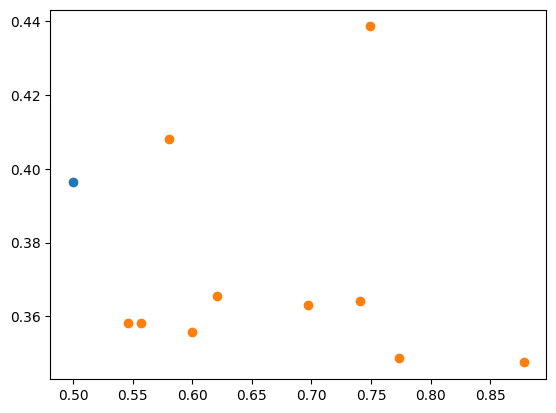

In [32]:
plt.scatter([0.5], ((data["train"][:, 1]-0.8)**2).mean())
plt.scatter(ood_scores_all, stds)

In [41]:
test_data = dataset.get_subset(
    "val")

test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=64, shuffle=True,
    num_workers=4, pin_memory=True)

In [42]:
ys = []
for (x, y, _) in test_loader:
    ys.append(y)

In [43]:
ys = np.concatenate(ys, axis=0)

(array([ 337., 1228.,  922.,  421.,  312.,  300.,  267.,   99.,   17.,
           6.]),
 array([-1.1444261 , -0.7708421 , -0.39725804, -0.02367401,  0.34991002,
         0.72349405,  1.0970781 ,  1.4706621 ,  1.8442461 ,  2.2178302 ,
         2.5914142 ], dtype=float32),
 <BarContainer object of 10 artists>)

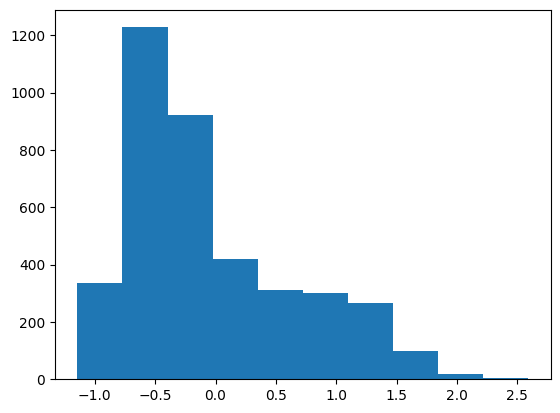

In [44]:
plt.hist(ys.squeeze())

In [45]:
ys.mean()

-0.04333939